### Notebook to conduct sanity check for Local orientation estimator

Docment for procedure [protocol](https://docs.google.com/document/d/1BbFIqXUUTLmvBj-PUGGL0hYFUHodUtFcWXOecR2pM10/edit?usp=sharing)

In [1]:
%matplotlib inline
import os
import cv2
import glob
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from scipy.stats import mode

In [93]:
import pandas as pd

In [87]:
## download plotly
!pip install plotly

    100% |################################| 12.9MB 647kB/s eta 0:00:01   55% |#################               | 7.2MB 33.9MB/s eta 0:00:01    76% |########################        | 9.9MB 48.1MB/s eta 0:00:01
  Stored in directory: /home/tkurihana/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [88]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# import MINST from tesnorflow
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
imgs = mnist.test.images
labels = mnist.test.labels
imgs.shape, labels.shape

((10000, 784), (10000,))

#### Get index list for each dataset  
Get one index at radom for each digit-class

In [30]:
digit_index_list = []
for i in range(10):
    tmp_indices = np.where(labels == i)[0] # get as a list
    tmp_index = tmp_indices[np.random.randint(0, len(tmp_indices),1)] 
    digit_index_list.append(tmp_index)

#### Select one image / each digit class

In [31]:
tmp_simgs_list = []
for i in digit_index_list:
    tmp_simgs_list.append(imgs[i].reshape(1,28,28))
simgs = np.concatenate(tmp_simgs_list,axis=0)

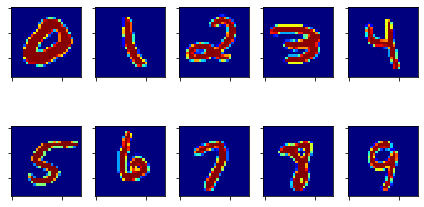

In [32]:
fig = plt.figure()
for i in range(10):
    idx = i+1
    ax = plt.subplot(2,5,idx)
    ax.imshow(simgs[i], cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

In [33]:
test_imgs = simgs[np.array([0,1,4,5,7,9])]

#### Replicate each digit class N times and then rotate each at random
N = 10 for frist sanity check


In [72]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [35]:
def _copy_fn(spatches, height=None, width=None, ch=1,copy_size=10):
    img_list = []
    for patch in spatches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    return imgs

In [116]:
def copy_rotate_fn(oimgs, height=None, width=None, channel=1, copy_size=10):
    _,h,w = oimgs.shape
    imgs= _copy_fn(oimgs,height=h, width=w,ch=channel,copy_size=copy_size)
    # rotate
    #radians = [i*math.pi/180 for i in np.random.randint(0,360, len(imgs))]
    #random.sample(range(1, 100), 3)
    X = random.sample(range(0,360),len(imgs))
    radians = [i*math.pi/180 for i in X]
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rimgs_tf = tf.image.resize_images(rimgs_tf, (height, width))
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    return rtest_imgs, X

get replicate and rotate imgs

In [43]:
### configration
copy_size=10
height=width=128

In [119]:
rimgs, rotate_angles = copy_rotate_fn(test_imgs, height=height, width=width, channel=1, copy_size=copy_size)

(60, 28, 28, 1)


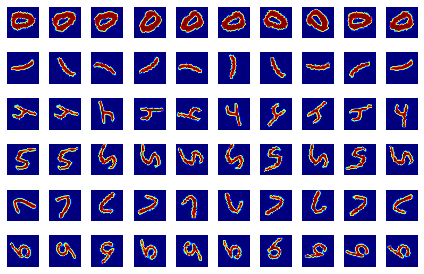

In [120]:
fig = plt.figure()
for i in range(60):
    idx = i+1
    ax = plt.subplot(6,10,idx)
    ax.imshow(rimgs[i, :,:,0], cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off() 
fig.tight_layout()
plt.show()

In [121]:
rotate_angles

[143,
 167,
 165,
 6,
 354,
 342,
 115,
 95,
 146,
 344,
 91,
 24,
 229,
 109,
 241,
 160,
 15,
 74,
 286,
 87,
 58,
 57,
 179,
 78,
 246,
 358,
 303,
 117,
 94,
 343,
 7,
 8,
 63,
 85,
 112,
 61,
 199,
 79,
 190,
 103,
 89,
 356,
 159,
 320,
 22,
 224,
 328,
 187,
 332,
 140,
 234,
 50,
 337,
 213,
 40,
 221,
 151,
 291,
 269,
 249]

#### Save imgs  per file

In [122]:
savedir = './mnist_figs'

In [123]:
def save_fn(imgs, sdir='./', figsize=(4,4), dpi=100):
    _imgs = np.squeeze(imgs)
    os.makedirs(sdir, exist_ok=True)
    #rcParams["savefig.format"] = 'jpg'
    for i in range(imgs.shape[0]):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1,1,1)
        ax.imshow(rimgs[i, :,:,0], cmap='gist_gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_axis_off()
        plt.savefig(os.path.join(sdir, f'img_{i}.jpg'))
        plt.close()

In [124]:
save_fn(rimgs, savedir)

Make sure if the image is fine or not

In [67]:
flist = glob.glob(os.path.join(savedir, '*.jpg'))

In [68]:
image = Image.open(flist[0])

In [69]:
image.size

(400, 400)

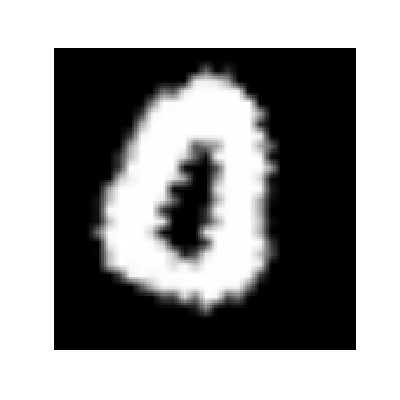

In [70]:
image

In [62]:
b = "/home/tkurihana/Paxis"

In [64]:
a = Image.open(b+"/cluster-6/fig_clustering_low-67011582_gray_n-5_N-20.jpg")

In [66]:
a.size

(400, 400)

In [71]:
import gc
gc.collect()

139243

### Import saved data

In [5]:
save_dir = '/home/tkurihana/Paxis/sanity/mnist_figs'

In [9]:
imgs_list = []
for i in range(60):
    _tmp =np.expand_dims(
        np.asarray(Image.open(os.path.join(save_dir, f'img_{i}.jpg')).convert('L')),
        axis=0 
    )
    imgs_list.append(_tmp)
rimgs = np.concatenate(imgs_list, axis=0)
rimgs.shape

(60, 400, 400)

------------------------------------
### Ananlysis seciton

In [133]:
angle_datadir = './mnist-result/N10-60-angle'
table_datadir = './mnist-result/N10-60-table'

In [136]:
angle_datadir = './mnist-result/N10-60-angle-negativePi'
table_datadir = './mnist-result/N10-60-table-negativePi'

In [12]:
def txt_reader(filename):
    data = []
    with open(filename, 'r') as f:
        lines = f.read()
        for line in lines.split('\n'):
            if len(line) > 0:
                data.append(float(line.strip(' ')))
    return np.asarray(data)

In [13]:
def csv_reader(filename):
    """ .csv file --> table of , and \n files
    """
    with open(filename, 'r') as f:
        lines = f.read()
        all_list = []
        for line in lines.split('\n'):
            data =line.split(',')
            data.remove('')
            msize = np.zeros((len(data))).astype(np.complex)
            for idx,i in enumerate(data):
                if len(i) > 0:
                    j = i.replace('i','j')
                    data[idx] = complex(j)
            
            if len(data) > 0:
                all_list.append(np.expand_dims(data, axis=0))
        array = np.concatenate(all_list, axis=0)
    return array

In [137]:
angle_alist= []
table_alist = []
for i in range(60):
    angle_alist.append(txt_reader(os.path.join(angle_datadir, f'img_{i}.txt')))
    table_alist.append(csv_reader(os.path.join(table_datadir, f'img_{i}_table.csv')))

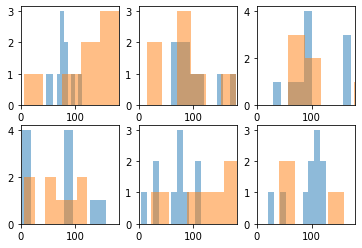

In [137]:
plt.figure()
alpha=0.5
for idx, (i,j) in enumerate(zip(np.array_split(angle_alist, 6),np.array_split(rotate_angles,6))):
    ax = plt.subplot(2,3,idx+1)
    #plt.hist(i.ravel(), alpha=alpha)
    plt.hist([ mode(k)[0][0] for k in i], alpha=alpha)
    plt.hist(j.ravel(), alpha=alpha)
    plt.xlim(0,180)
plt.show()

In [30]:
rotate_angles = [143,
 167,
 165,
 6,
 354,
 342,
 115,
 95,
 146,
 344,
 91,
 24,
 229,
 109,
 241,
 160,
 15,
 74,
 286,
 87,
 58,
 57,
 179,
 78,
 246,
 358,
 303,
 117,
 94,
 343,
 7,
 8,
 63,
 85,
 112,
 61,
 199,
 79,
 190,
 103,
 89,
 356,
 159,
 320,
 22,
 224,
 328,
 187,
 332,
 140,
 234,
 50,
 337,
 213,
 40,
 221,
 151,
 291,
 269,
 249]

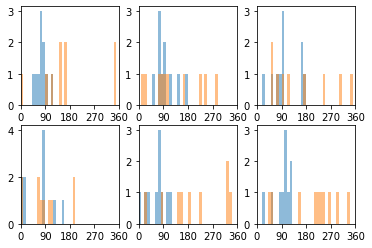

In [63]:
plt.figure()
alpha=0.5
brange=np.arange(0,360,10)
for idx, (i,j) in enumerate(
    zip(np.array_split(angle_alist, 6),np.array_split(rotate_angles,6))):
    ax = plt.subplot(2,3,idx+1)
    #plt.hist(i.ravel(), alpha=alpha)
    plt.hist([ mode(k)[0][0] for k in i], bins=brange, alpha=alpha)
    plt.hist(j.ravel(), bins=brange, alpha=alpha)
    plt.xlim(0,360)
    plt.xticks(np.arange(0,361,90))
plt.show()

###### Visualize on the original images

In [10]:
def quiver_fn(img, orient):
    step1 = img.shape[0]/orient.shape[0]
    step2 = img.shape[1]/orient.shape[1]
    x, y = np.meshgrid(
        np.arange(step1/2,img.shape[0],step1),
        np.arange(step2/2,img.shape[1],step2),
    )
    u = -orient.real / abs(orient)
    v = -1*orient.imag / abs(orient)
    """ Must flip v, u instead of u, v for converting matlab to python system
    """
    return x,y,v, u
    #dx = np.array([i for i in range(0,len(x),2)])
    #return x[dx,dx], y[dx,dx], v[dx,dx], u[dx,dx]
    #return x[1:,1:], y[1:,1:], v[1:,1:], u[1:,1:]

In [28]:
def base_plot(imgs, orients, size=(4,3),dpi=100, 
              nrow=2, ncol=5, expname=None, linewidth=5,headlength=15,
              scale=4,width=0.01,alpha=1,headwidth=3,color='black',
              cmap='jet', nmin=0, nmax=1, nclusters=6):
    fig,ax  = plt.subplots(ncol, nrow,figsize=size,dpi=dpi)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    imgs_list = np.array_split(imgs, nclusters)
    ix = 0
    for icol, cluster in enumerate(range(nclusters)):
        _imgs = imgs_list[icol]
        _orients = orients[icol]
        for ii,i in enumerate(_imgs) :
            ax[ii][icol].imshow(i,
                                vmin=nmin, vmax=nmax, cmap=cmap,alpha=alpha)
            ax[ii][icol].set_xticklabels([])
            ax[ii][icol].set_yticklabels([])
            ax[ii][icol].axis('off')
            
            # quiver
            #print(_orients.shape);stop
            x,y,u,v = quiver_fn(i, _orients[ii])
            #print(x,y,u,v)
            ax[ii][icol].quiver(x,y,u,v,color=color, 
                                linewidth=linewidth,units='width',
                                scale=scale, width=width, headwidth=headwidth)
            ix+=1
    fig.tight_layout()
    plt.show()
    #plt.savefig('./all_{}_N-{}.png'.format(expname, len(imgs_list)))
    plt.close()

In [17]:
len(table_alist)

60

In [38]:
np.amax(angle_alist),np.amin(angle_alist)

(179.18, 2.11)

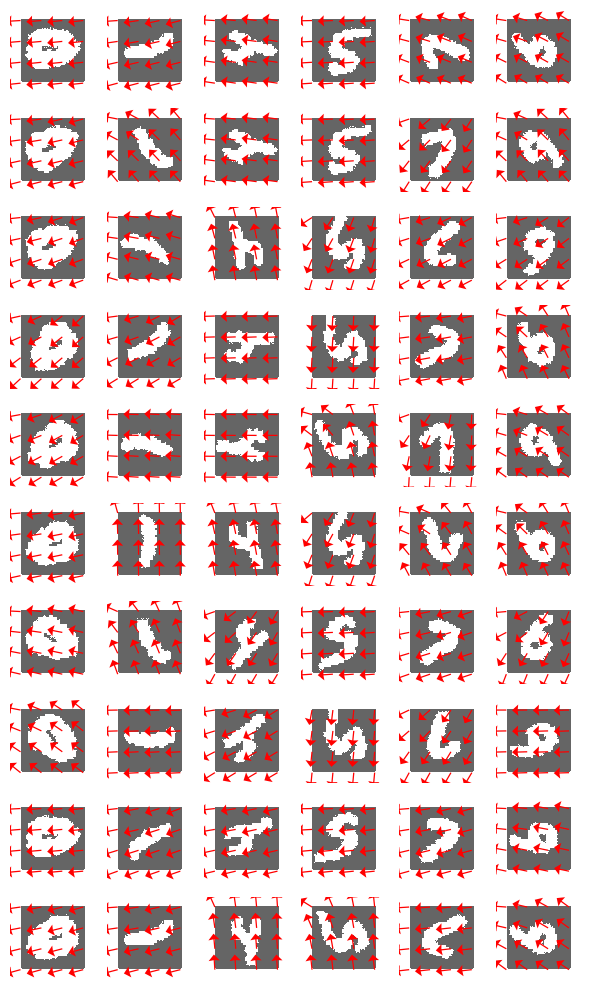

In [29]:
# RI model
base_plot(rimgs, orients=np.array_split(table_alist,6),
          size=(6,10),dpi=100, nrow=6, ncol=10, 
          linewidth=8, nclusters=6,cmap='gist_gray',color='red',
          headlength=25,headwidth=9,alpha=0.6,scale=5.5, width=0.015)

In [59]:
def base_plot2(imgs, orients, size=(4,3),dpi=100, titles=[],
              nrow=2, ncol=5, expname=None, linewidth=5,headlength=15,
              scale=4,width=0.01,alpha=1,headwidth=3,color='black',
              cmap='jet', nmin=0, nmax=1, nclusters=6, fontsize=12):
    fig,ax  = plt.subplots(ncol, nrow,figsize=size,dpi=dpi)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    imgs_list = np.array_split(imgs, nclusters)
    ix = 0
    for icol, cluster in enumerate(range(nclusters)):
        _imgs = imgs_list[icol]
        _orients = orients[icol]
        for ii,i in enumerate(_imgs) :
            ax[ii][icol].imshow(i,
                                vmin=nmin, vmax=nmax, cmap=cmap,alpha=alpha)
            ax[ii][icol].set_xticklabels([])
            ax[ii][icol].set_yticklabels([])
            ax[ii][icol].axis('off')
            
            # quiver
            #print(_orients.shape);stop
            x,y,u,v = quiver_fn(i, _orients[ii])
            #print(x,y,u,v)
            ax[ii][icol].quiver(x,y,u,v,color=color, 
                                linewidth=linewidth,units='width',
                                scale=scale, width=width, headwidth=headwidth)
           
            ax[ii][icol].set_title(f"${int(np.median(titles[ix]) )}^\circ$", 
                                  fontsize=fontsize,y=.9)
            ix+=1
    fig.tight_layout()
    plt.show()
    plt.savefig('./mnist-with-arrows_08042020.png')
    plt.close()

In [52]:
np.median(angle_alist[0])

84.205

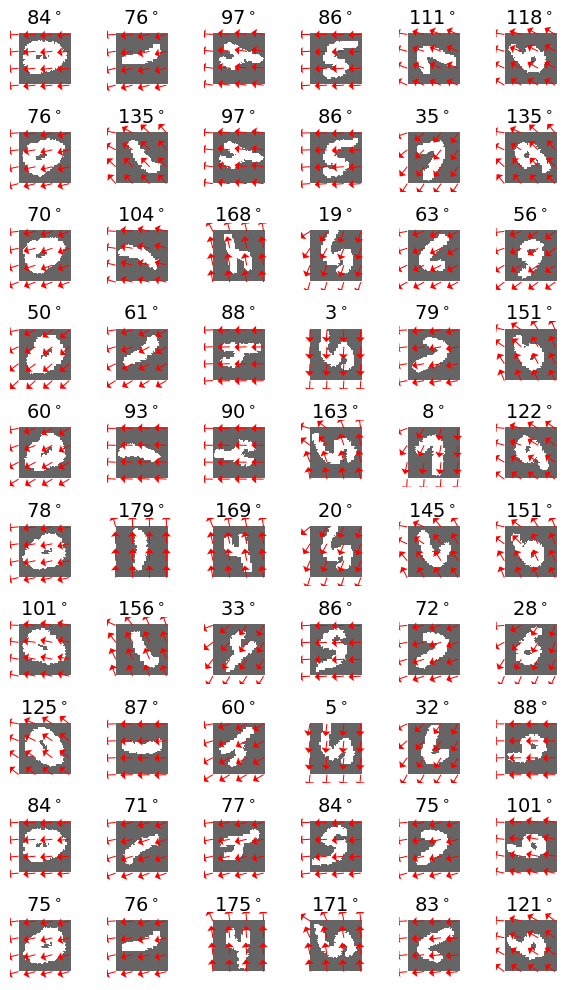

In [61]:
# RI model
base_plot2(rimgs, orients=np.array_split(table_alist,6),
          size=(6,10),dpi=100, nrow=6, ncol=10, titles=angle_alist,
          linewidth=8, nclusters=6,cmap='gist_gray',color='red',
          headlength=25,headwidth=9,alpha=0.6,scale=5.5, width=0.015,fontsize=14)

##### Without plus Pi operation

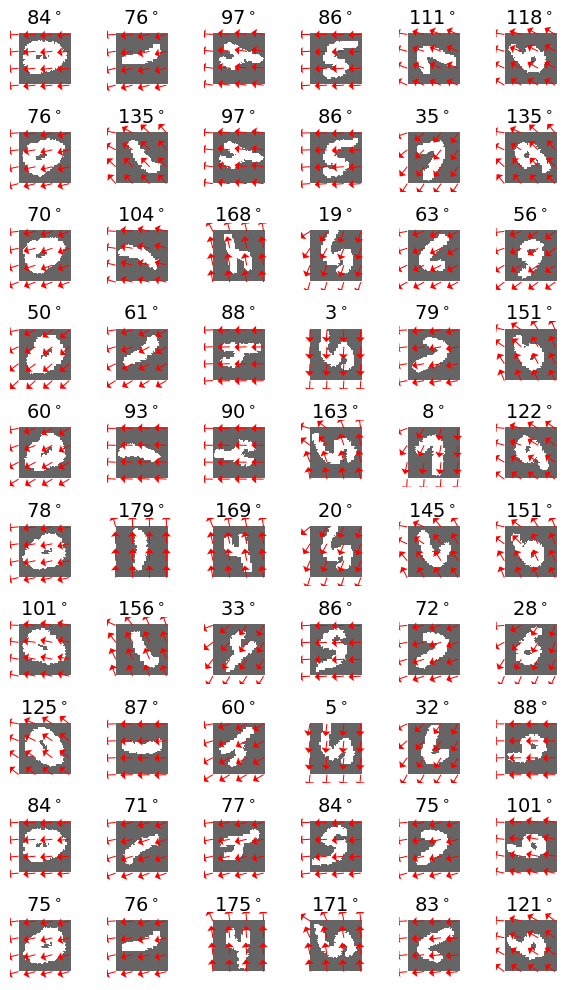

In [138]:
# RI model
base_plot2(rimgs, orients=np.array_split(table_alist,6),
          size=(6,10),dpi=100, nrow=6, ncol=10, titles=angle_alist,
          linewidth=8, nclusters=6,cmap='gist_gray',color='red',
          headlength=25,headwidth=9,alpha=0.6,scale=5.5, width=0.015,fontsize=14)

###### Rose wind

In [89]:
from pylab import *
from matplotlib.colors import Colormap
def get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

In [119]:
def compute_dfangle(all_list, nclusters=None,
                    topK=None, expname=None, preprocess=False, nangle=16, debug=False):
    logs_list = []
    for cluster, tmp_all_list in enumerate(all_list):
        tmp_list = [ ]
        for i in tmp_all_list:
            tmp_list.extend(i)
        # dataframe
        angles = []
        #ag = np.linspace(0,360,nangle)
        ag = np.arange(0,360,nangle)
        amax = 360+ag[1]
        for idx, i in enumerate(ag[:-1]):
            tmp = list(filter(lambda x : x  > ag[idx] and x <= ag[idx+1], tmp_list))
            angles.append(len(tmp))
        df = pd.DataFrame(np.array(angles))
        df.columns = ['frequency']
        df['theta'] = np.array([ float((i+ag[idx+1])/2) for idx, i in enumerate(ag[:-1])])
        
        logs_list.append(df)
    return logs_list

In [130]:
logs_ri_list = compute_dfangle(np.array_split(angle_alist,6), nclusters=6, nangle=1)

In [131]:
logs_ri_list[0].frequency.values

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  2,  2,  0,
        2,  0,  2,  0,  0,  0,  0,  4,  3,  1,  3,  2,  0,  0,  2,  0,  1,
        0,  6,  4,  2,  2,  0,  4, 11,  6,  9,  9,  5,  1,  1,  5,  4, 22,
        6,  2,  1,  0,  0,  0,  0,  1,  0,  0,  0,  2,  1,  0,  0,  2,  3,
        6,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  2,  2,  0,  2,  2,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

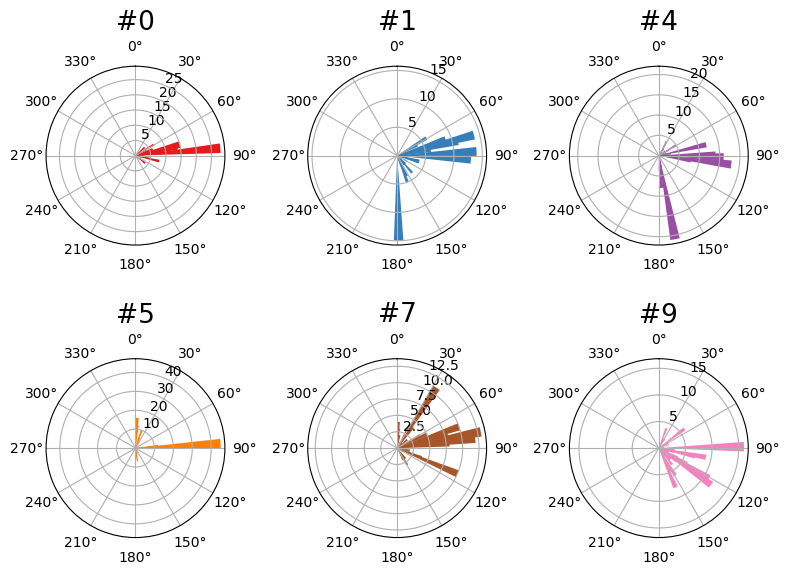

In [126]:
# Compute pie slices
nclusters = 6
cluster_list = [0,1,4,5,7,9]
mycolors =get_colors(n=nclusters+1, cmap_name='Set1')
fig = plt.figure(figsize=(8,6), dpi=100)
for cluster in range(6):
    idx = cluster + 1
    ax = plt.subplot(2,3,idx, projection='polar')
    #width = 1*(2*np.pi/28) #np.pi / 16
    width = 1*(2*np.pi/56) #np.pi / 16
    df = logs_ri_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
    ax.set_title("#{}".format(cluster_list[cluster]),fontsize=19, pad=20)
    ax.set_thetagrids(range(0, 360, 30))
    ax.set_theta_zero_location('N')  # set direction of zero
    ax.set_theta_direction(-1) # set rotation as clockwise
fig.tight_layout()
plt.show()

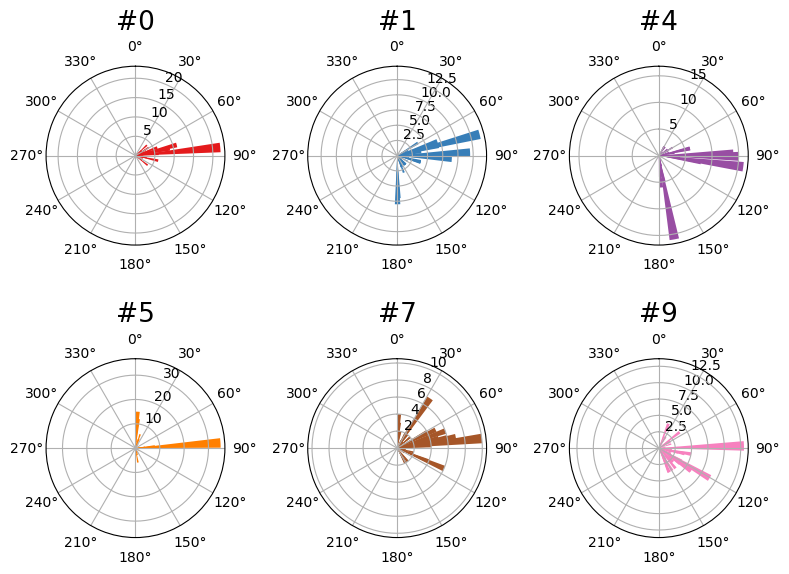

In [132]:
# Compute pie slices
nclusters = 6
cluster_list = [0,1,4,5,7,9]
mycolors =get_colors(n=nclusters+1, cmap_name='Set1')
fig = plt.figure(figsize=(8,6), dpi=100)
for cluster in range(6):
    idx = cluster + 1
    ax = plt.subplot(2,3,idx, projection='polar')
    #width = 1*(2*np.pi/28) #np.pi / 16
    width = 1*(2*np.pi/56) #np.pi / 16
    df = logs_ri_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
    ax.set_title("#{}".format(cluster_list[cluster]),fontsize=19, pad=20)
    ax.set_thetagrids(range(0, 360, 30))
    ax.set_theta_zero_location('N')  # set direction of zero
    ax.set_theta_direction(-1) # set rotation as clockwise
fig.tight_layout()
plt.show()